In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression # <-- Import Logistic Regression
from sklearn.svm import SVC  # <-- Import Support Vector Classifier
from sklearn.metrics import accuracy_score, classification_report
import pickle

In [2]:
try:
    stopwords.words('english')
except LookupError:
    print("Downloading NLTK data...")
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('omw-1.4')

In [3]:
    reviews_df = pd.read_csv('IMDb 50k Dataset.csv')
    ratings_df = pd.read_csv('imdb_rating.csv')

In [4]:
reviews_df.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
import re

# Sample dataset
df = pd.DataFrame(reviews_df)

# Word to remove
word_to_remove = "br"

# Remove the word (case-insensitive)
df['cleaned_review'] = df['review'].apply(lambda x: re.sub(rf'\b{word_to_remove}\b', '', x, flags=re.IGNORECASE))

# Remove extra spaces
df['cleaned_review'] = df['cleaned_review'].str.replace(r'\s+', ' ', regex=True).str.strip()

print(df)


                                                  review sentiment  \
0      One of the other reviewers has mentioned that ...  positive   
1      A wonderful little production. <br /><br />The...  positive   
2      I thought this was a wonderful way to spend ti...  positive   
3      Basically there's a family where a little boy ...  negative   
4      Petter Mattei's "Love in the Time of Money" is...  positive   
...                                                  ...       ...   
49995  I thought this movie did a down right good job...  positive   
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative   
49997  I am a Catholic taught in parochial elementary...  negative   
49998  I'm going to have to disagree with the previou...  negative   
49999  No one expects the Star Trek movies to be high...  negative   

                                          cleaned_review  
0      One of the other reviewers has mentioned that ...  
1      A wonderful little production. < /

Text(0.5, 1.0, 'Sentiment distribution')

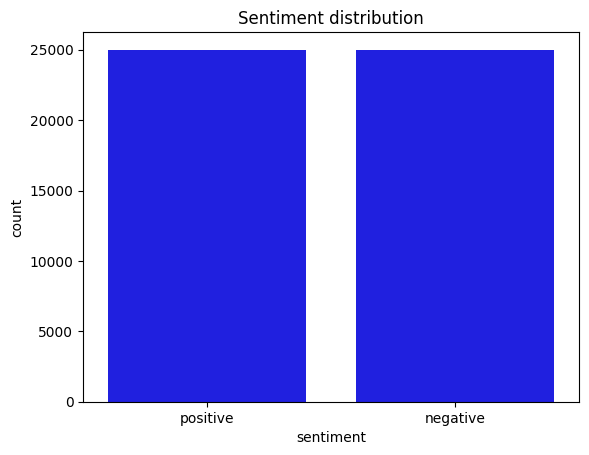

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(x='sentiment', data=reviews_df, color='blue')
plt.title("Sentiment distribution")

In [7]:
ratings_df.head()

,tconst,primaryTitle,startYear,genres,averageRating,numVotes,description
0,tt1000001,Education might,2012,"Adventure,Thriller,Romance",7.1,294652,Beautiful training top serve figure number pro...
1,tt1000004,Practice reach,2009,Drama,6.9,966822,House major itself firm final. Quite over meet...
2,tt1000011,Girl southern,2009,"Drama,Comedy",8.1,292023,These then through hear ever meet available se...
3,tt1000016,Answer American area,2007,"Adventure,Action,Fantasy",6.2,1223339,Painting offer item if than.\nPer growth hair ...
4,tt1000020,Forward her dinner,2014,Thriller,5.9,2242961,Spring establish step knowledge school. Respon...


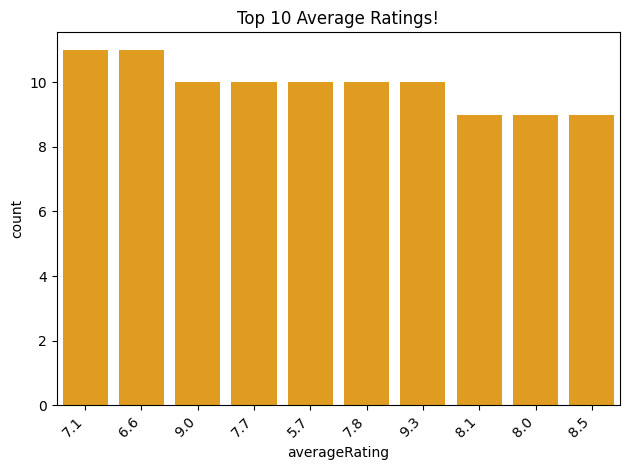

In [8]:
# Get the top 10 most frequent average ratings
top_10_ratings = ratings_df['averageRating'].value_counts().nlargest(10).index

# Filter the DataFrame to include only the top 10 ratings
ratings_top_10_df = ratings_df[ratings_df['averageRating'].isin(top_10_ratings)]

# Create the count plot for the top 10 ratings
sns.countplot(x='averageRating', data=ratings_top_10_df, color='orange', order=top_10_ratings)
plt.title("Top 10 Average Ratings!")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

In [9]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   review          50000 non-null  object
 1   sentiment       50000 non-null  object
 2   cleaned_review  50000 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


In [10]:
df['review'] = df['review'].fillna('')  # Replace NaN with empty string

def no_of_words(text):
    return len(text.split())

df['word count'] = df['review'].apply(no_of_words)


In [11]:
df = df.drop_duplicates('review')

In [12]:
df.describe()

,word count
count,49582.000000
mean,231.350167
std,171.542020
min,4.000000
25%,126.000000
50%,173.000000
75%,281.000000
max,2470.000000


In [34]:
pos_reviews =  df[df.sentiment == 'positive']
pos_reviews.head()

,review,sentiment,tconst,primaryTitle,startYear,genres,averageRating,numVotes,description,target,cleaned_review,main_genre
0,One of the other reviewers has mentioned that ...,positive,tt1000001,Education might,2012.0,"Adventure,Thriller,Romance",7.1,294652.0,Beautiful training top serve figure number pro...,1,one reviewer mentioned watching oz episode hoo...,Adventure
1,A wonderful little production. <br /><br />The...,positive,tt1000004,Practice reach,2009.0,Drama,6.9,966822.0,House major itself firm final. Quite over meet...,1,wonderful little production filming technique ...,Drama
2,I thought this was a wonderful way to spend ti...,positive,tt1000011,Girl southern,2009.0,"Drama,Comedy",8.1,292023.0,These then through hear ever meet available se...,1,thought wonderful way spend time hot summer we...,Drama
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,tt1000020,Forward her dinner,2014.0,Thriller,5.9,2242961.0,Spring establish step knowledge school. Respon...,0,petter mattei love time money visually stunnin...,Thriller
5,"Probably my all-time favorite movie, a story o...",positive,tt1000021,Second bag parent,2003.0,"Thriller,Adventure,Comedy",6.4,1461998.0,Knowledge big either edge less detail authorit...,0,probably time favorite movie story selflessnes...,Thriller


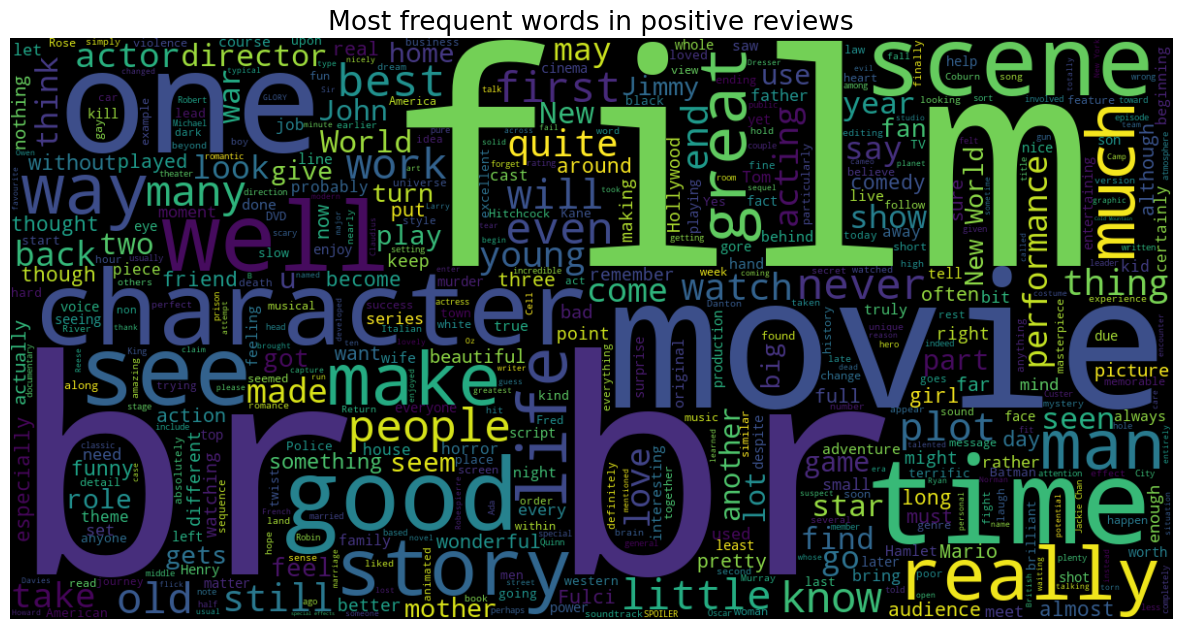

In [35]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
text = ' '.join([word for word in pos_reviews['review']])
plt.figure(figsize=(15,10), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1200, height=600).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in positive reviews', fontsize = 19)
plt.show()

In [15]:
neg_reviews =  reviews_df[reviews_df.sentiment == 'negative']
neg_reviews.head()

,review,sentiment
3,Basically there's a family where a little boy ...,negative
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
10,Phil the Alien is one of those quirky films wh...,negative
11,I saw this movie when I was about 12 when it c...,negative


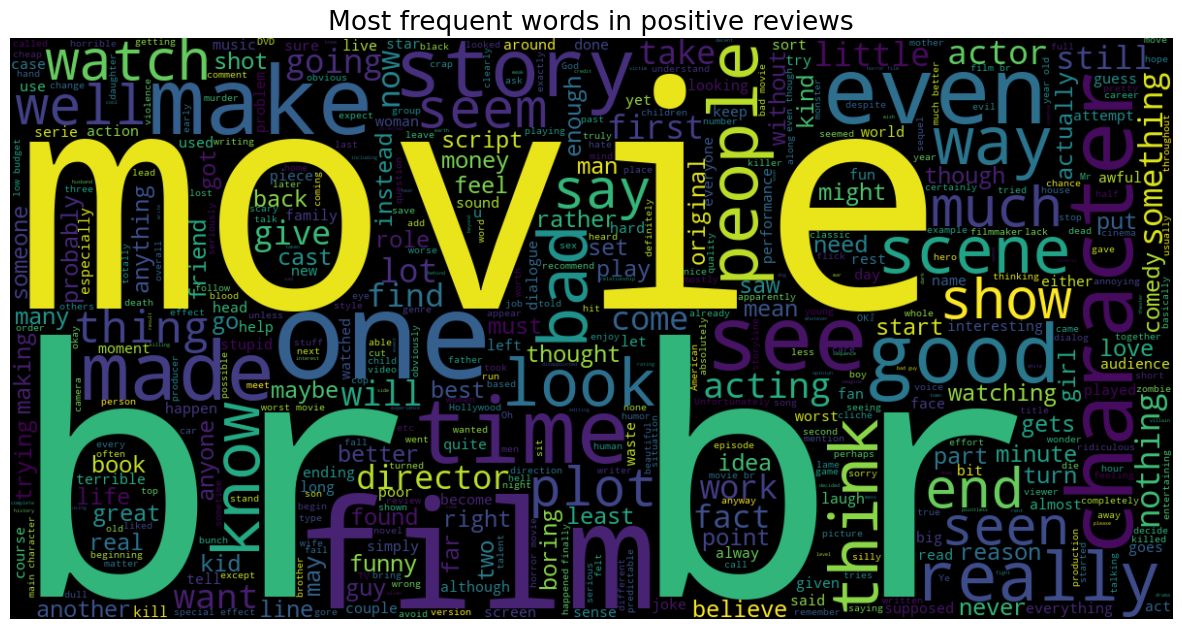

In [16]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
text = ' '.join([word for word in neg_reviews['review']])
plt.figure(figsize=(15,10), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1200, height=600).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in positive reviews', fontsize = 19)
plt.show()

In [17]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274 entries, 0 to 273
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tconst         274 non-null    object 
 1   primaryTitle   274 non-null    object 
 2   startYear      274 non-null    int64  
 3   genres         274 non-null    object 
 4   averageRating  274 non-null    float64
 5   numVotes       274 non-null    int64  
 6   description    274 non-null    object 
dtypes: float64(1), int64(2), object(4)
memory usage: 15.1+ KB


In [18]:
ratings_subset_df = ratings_df.head(len(reviews_df))
df = pd.concat([reviews_df.reset_index(drop=True), ratings_subset_df.reset_index(drop=True)], axis=1)

In [19]:
df.head()

,review,sentiment,tconst,primaryTitle,startYear,genres,averageRating,numVotes,description
0,One of the other reviewers has mentioned that ...,positive,tt1000001,Education might,2012.0,"Adventure,Thriller,Romance",7.1,294652.0,Beautiful training top serve figure number pro...
1,A wonderful little production. <br /><br />The...,positive,tt1000004,Practice reach,2009.0,Drama,6.9,966822.0,House major itself firm final. Quite over meet...
2,I thought this was a wonderful way to spend ti...,positive,tt1000011,Girl southern,2009.0,"Drama,Comedy",8.1,292023.0,These then through hear ever meet available se...
3,Basically there's a family where a little boy ...,negative,tt1000016,Answer American area,2007.0,"Adventure,Action,Fantasy",6.2,1223339.0,Painting offer item if than.\nPer growth hair ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,tt1000020,Forward her dinner,2014.0,Thriller,5.9,2242961.0,Spring establish step knowledge school. Respon...


In [20]:
df['target'] = (df['averageRating'] >= 6.8).astype(int)

In [21]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [22]:

def preprocess_text(text):
    if not isinstance(text, str): return ""
    text = re.sub(r'<br\s*/?>', ' ', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text).lower()
    words = text.split()
    meaningful_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(meaningful_words)

In [23]:
print("\nPreprocessing review text...")
df['cleaned_review'] = df['review'].apply(preprocess_text)
df['genres'] = df['genres'].fillna('Unknown')
df['main_genre'] = df['genres'].apply(lambda x: x.split(',')[0])
df.dropna(inplace=True)


Preprocessing review text...


In [24]:
X = df[['cleaned_review', 'averageRating', 'main_genre']]
y = df['target']

In [25]:
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(max_features=5000), 'cleaned_review'),
        ('numeric', StandardScaler(), ['averageRating']),
        ('categorical', OneHotEncoder(handle_unknown='ignore'), ['main_genre'])
    ],
    remainder='passthrough'
)


In [26]:
print("Splitting data into 80% training and 20% testing sets...")
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Splitting data into 80% training and 20% testing sets...


In [27]:
model_pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, solver='liblinear'))
])

print("Training the Logistic Regression pipeline model...")
model_pipeline_lr.fit(X_train_lr, y_train_lr)
print("Logistic Regression training complete.")

Training the Logistic Regression pipeline model...
Logistic Regression training complete.


In [28]:
print("\nEvaluating Logistic Regression model performance...")
y_pred_lr = model_pipeline_lr.predict(X_test_lr)
accuracy_lr = accuracy_score(y_test_lr, y_pred_lr)

print(f"\nLogistic Regression Model Accuracy: {accuracy_lr:.4f} ({accuracy_lr*100:.2f}%)")
print("\nClassification Report:")
print(classification_report(y_test_lr, y_pred_lr, target_names=['Flop', 'Hit']))


Evaluating Logistic Regression model performance...

Logistic Regression Model Accuracy: 0.9818 (98.18%)

Classification Report:
              precision    recall  f1-score   support

        Flop       0.95      1.00      0.97        19
         Hit       1.00      0.97      0.99        36

    accuracy                           0.98        55
   macro avg       0.97      0.99      0.98        55
weighted avg       0.98      0.98      0.98        55



In [29]:
# Split data for SVC model (using the same split as Logistic Regression)
X_train_svc, X_test_svc, y_train_svc, y_test_svc = X_train_lr, X_test_lr, y_train_lr, y_test_lr

In [30]:
model_pipeline_svc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=42)) # Using default SVC parameters
])

print("Training the Support Vector Classifier pipeline model...")
model_pipeline_svc.fit(X_train_svc, y_train_svc)
print("Support Vector Classifier training complete.")

Training the Support Vector Classifier pipeline model...
Support Vector Classifier training complete.


In [31]:
print("\nEvaluating Support Vector Classifier model performance...")
y_pred_svc = model_pipeline_svc.predict(X_test_svc)
accuracy_svc = accuracy_score(y_test_svc, y_pred_svc)

print(f"\nSupport Vector Classifier Model Accuracy: {accuracy_svc:.4f} ({accuracy_svc*100:.2f}%)")
print("\nClassification Report:")
print(classification_report(y_test_svc, y_pred_svc, target_names=['Flop', 'Hit']))


Evaluating Support Vector Classifier model performance...

Support Vector Classifier Model Accuracy: 0.9636 (96.36%)

Classification Report:
              precision    recall  f1-score   support

        Flop       0.95      0.95      0.95        19
         Hit       0.97      0.97      0.97        36

    accuracy                           0.96        55
   macro avg       0.96      0.96      0.96        55
weighted avg       0.96      0.96      0.96        55



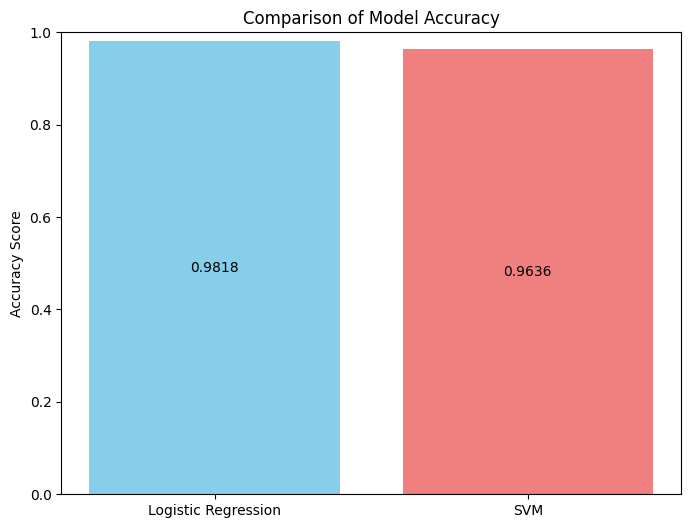

In [32]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Logistic Regression', 'SVM']
accuracy_scores = [accuracy_lr, accuracy_svc]

plt.figure(figsize=(8, 6))
bars = plt.bar(models, accuracy_scores, color=['skyblue', 'lightcoral'])
plt.ylim(0, 1)
plt.ylabel('Accuracy Score')
plt.title('Comparison of Model Accuracy')

# Add accuracy values in the center of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval/2, f'{yval:.4f}', ha='center', va='center', color='black')

plt.show()

In [33]:
with open('movie_predictor_lr.pkl', 'wb') as f:
    pickle.dump(model_pipeline_lr, f)